In [1]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import cv2
import numpy as np
import os
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [3]:
def normalize_keypoints(sequence):
    # Reshape sequence to (frames, keypoints, coordinates)
    sequence = sequence.reshape(sequence.shape[0], -1, 3)
    normalized_sequence = []
    for frame in sequence:
        # Left Hand
        left_hand = frame[:21, :]
        if np.any(left_hand):
            left_hand_center = left_hand[0, :]  # Wrist
            left_hand = left_hand - left_hand_center  # Center the hand
            hand_size = np.linalg.norm(left_hand[9, :])  # Middle finger MCP
            if hand_size > 0:
                left_hand = left_hand / hand_size  # Scale the hand
            else:
                left_hand = np.zeros((21, 3))
        else:
            left_hand = np.zeros((21, 3))

        # Right Hand
        right_hand = frame[21:, :]
        if np.any(right_hand):
            right_hand_center = right_hand[0, :]  # Wrist
            right_hand = right_hand - right_hand_center  # Center the hand
            hand_size = np.linalg.norm(right_hand[9, :])  # Middle finger MCP
            if hand_size > 0:
                right_hand = right_hand / hand_size  # Scale the hand
            else:
                right_hand = np.zeros((21, 3))
        else:
            right_hand = np.zeros((21, 3))

        # Concatenate normalized keypoints
        frame_normalized = np.concatenate([left_hand, right_hand], axis=0)
        normalized_sequence.append(frame_normalized.flatten())
    return np.array(normalized_sequence)


In [ ]:
# !unzip '/content/drive/MyDrive/Colab/Autumn 2025/Untitled folder/AUSLAN_Data.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/AUSLAN_Data/P/28/29.npy  
  inflating: /content/__MACOSX/AUSLAN_Data/P/28/._29.npy  
  inflating: /content/AUSLAN_Data/P/28/15.npy  
  inflating: /content/__MACOSX/AUSLAN_Data/P/28/._15.npy  
  inflating: /content/AUSLAN_Data/P/28/14.npy  
  inflating: /content/__MACOSX/AUSLAN_Data/P/28/._14.npy  
  inflating: /content/AUSLAN_Data/P/28/28.npy  
  inflating: /content/__MACOSX/AUSLAN_Data/P/28/._28.npy  
  inflating: /content/AUSLAN_Data/P/28/16.npy  
  inflating: /content/__MACOSX/AUSLAN_Data/P/28/._16.npy  
  inflating: /content/AUSLAN_Data/P/28/17.npy  
  inflating: /content/__MACOSX/AUSLAN_Data/P/28/._17.npy  
  inflating: /content/AUSLAN_Data/P/28/13.npy  
  inflating: /content/__MACOSX/AUSLAN_Data/P/28/._13.npy  
  inflating: /content/AUSLAN_Data/P/28/12.npy  
  inflating: /content/__MACOSX/AUSLAN_Data/P/28/._12.npy  
  inflating: /content/AUSLAN_Data/P/28/10.npy  
  inflating: /content/__MACOSX/AUSLAN_Data/P/

In [4]:
# Define paths and actions
DATA_PATH = os.path.join('/Users/robayedashraf/Downloads/LSTM_AUSLAN_Real_Time_FigerSpelling_Recognization-main/Real_Time_Gensture_Recognization/AUSLAN_Data')

# Actions to detect
actions = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
                    'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

# Number of sequences and sequence length
no_sequences = 50
sequence_length = 30

# Label mapping
label_map = {label: num for num, label in enumerate(actions)}

In [5]:
sequences, labels = [], []
for action in actions:
    for sequence_num in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence_num), f"{frame_num}.npy"))
            # Extract only hand keypoints

            res = res[-(21*3*2):]  # Assuming hand keypoints are at the end
            window.append(res)
        window = np.array(window)

        # Normalize keypoints
        window_normalized = normalize_keypoints(window)
        sequences.append(window_normalized)
        labels.append(label_map[action])


In [6]:
sequences = np.array(sequences)
labels = np.array(labels)

In [7]:
from sklearn.model_selection import train_test_split

# Optionally normalize data if needed, for example:
# sequences = sequences.astype('float32') / np.max(sequences)

X_train, X_test, y_train, y_test = train_test_split(
    sequences, labels, test_size=0.3, random_state=42, stratify=labels
)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

num_classes = 26
feature_dim = sequences.shape[2]  # Extracted from your npy files
sequence_length = sequences.shape[1]  # This should be 30

model = Sequential([
    LSTM(64, input_shape=(sequence_length, feature_dim), return_sequences=True),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        48,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,226 (246.98 KB)

 Trainable params: 63,226 (246.98 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0440 - loss: 3.2476 - val_accuracy: 0.1462 - val_loss: 3.0564
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1254 - loss: 3.0095 - val_accuracy: 0.3282 - val_loss: 2.6232
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2537 - loss: 2.6053 - val_accuracy: 0.4923 - val_loss: 2.1129
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4097 - loss: 2.1756 - val_accuracy: 0.6154 - val_loss: 1.6073
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5383 - loss: 1.7223 - val_accuracy: 0.7692 - val_loss: 1.2018
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6214 - loss: 1.3757 - val_accuracy: 0.8308 - val_loss: 0.9394
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7019 - loss: 1.1514 - val_accuracy: 0.8538 - val_loss: 0.8229
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7190 - loss: 1.0255 - val_accuracy: 0.8256 - v

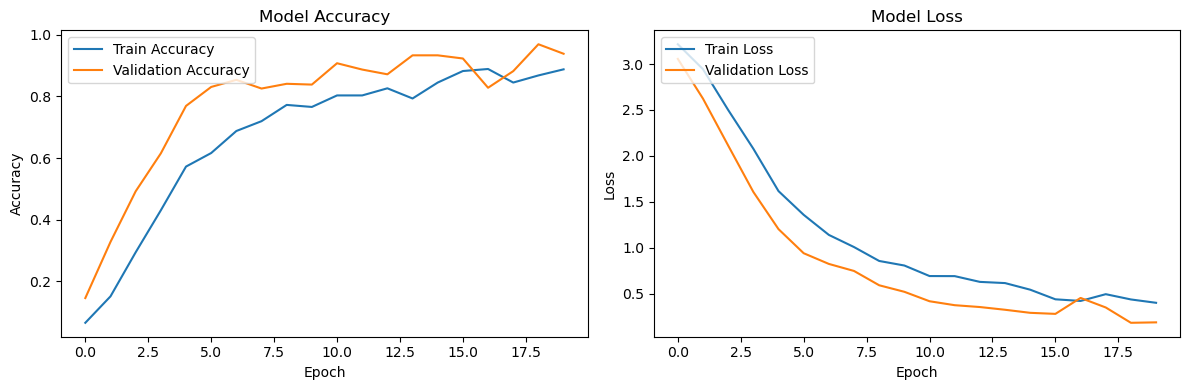

In [18]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# After training your model, call the function:
plot_training_history(history)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalAveragePooling1D

num_classes = 26
feature_dim = sequences.shape[2]  # Extracted from your npy files
sequence_length = sequences.shape[1]  # This should be 30

model = Sequential([
    # First convolutional block with 64 filters and kernel size of 3
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(sequence_length, feature_dim)),
    Dropout(0.4),
    
    # Second convolutional block with 32 filters
    Conv1D(32, kernel_size=3, activation='relu'),
    Dropout(0.4),
    
    # Global pooling to reduce the feature maps to a single vector
    GlobalAveragePooling1D(),
    
    # Dense layers similar to your original model
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │        24,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 26, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,346 (126.35 KB)

 Trainable params: 32,346 (126.35 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0463 - loss: 3.2413 - val_accuracy: 0.2103 - val_loss: 2.9776
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2145 - loss: 2.8721 - val_accuracy: 0.3231 - val_loss: 2.3811
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3213 - loss: 2.3380 - val_accuracy: 0.5564 - val_loss: 1.7163
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5118 - loss: 1.6799 - val_accuracy: 0.7487 - val_loss: 1.0306
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7124 - loss: 1.0591 - val_accuracy: 0.8308 - val_loss: 0.6341
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7824 - loss: 0.7244 - val_accuracy: 0.8564 - val_loss: 0.4682
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8285 - loss: 0.5227 - val_accuracy: 0.8821 - val_loss: 0.3616
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8454 - loss: 0.4348 - val_accuracy: 0.9205 - val_loss:

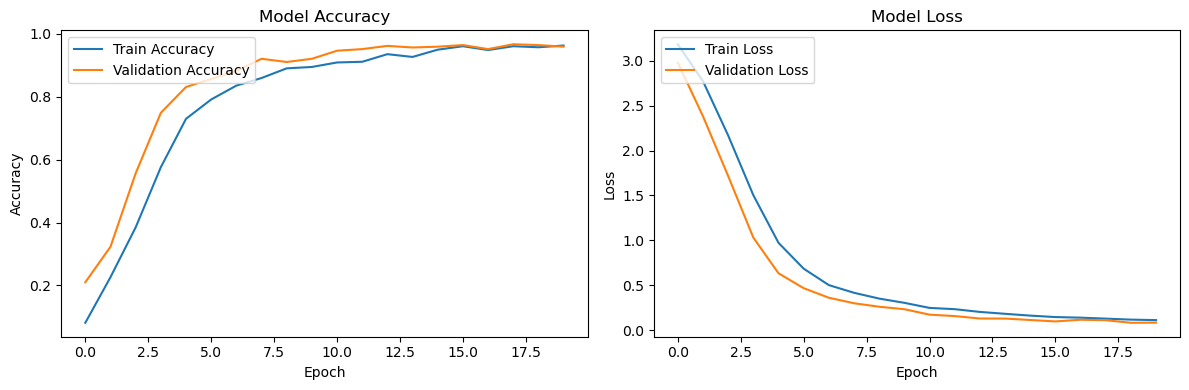

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# After training your model, call the function:
plot_training_history(history)

In [17]:
model.save('model.h5')

In [14]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from collections import deque

# Define actions (A-Z)
actions = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
                    'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

# Load your trained model
model = tf.keras.models.load_model('model.h5')  # Update the path if needed

# Initialize MediaPipe holistic model and drawing utilities
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_styled_landmarks(image, results):
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
        )
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )

def extract_keypoints(results):
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]
                         ).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]
                          ).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([left_hand, right_hand])

def normalize_keypoints(sequence):
    sequence = sequence.reshape(sequence.shape[0], -1, 3)
    normalized_sequence = []
    for frame in sequence:
        # Process left hand
        left_hand = frame[:21, :]
        if np.any(left_hand):
            left_hand_center = left_hand[0, :]
            left_hand = left_hand - left_hand_center
            hand_size = np.linalg.norm(left_hand[9, :])
            left_hand = left_hand / hand_size if hand_size > 0 else np.zeros((21, 3))
        else:
            left_hand = np.zeros((21, 3))
        # Process right hand
        right_hand = frame[21:, :]
        if np.any(right_hand):
            right_hand_center = right_hand[0, :]
            right_hand = right_hand - right_hand_center
            hand_size = np.linalg.norm(right_hand[9, :])
            right_hand = right_hand / hand_size if hand_size > 0 else np.zeros((21, 3))
        else:
            right_hand = np.zeros((21, 3))
        frame_normalized = np.concatenate([left_hand, right_hand], axis=0)
        normalized_sequence.append(frame_normalized.flatten())
    return np.array(normalized_sequence)

def preprocess_frame(results):
    keypoints = extract_keypoints(results)
    keypoints = keypoints.reshape(1, -1)
    keypoints = normalize_keypoints(keypoints)
    return keypoints[0]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    frame_height, frame_width, _ = output_frame.shape
    left_column_letters = 13
    top_spacing = 40
    label_height = 30
    label_width = 120
    for num, prob in enumerate(res):
        if num < left_column_letters:
            x_offset = 0
            y_position = top_spacing + num * label_height
            cv2.rectangle(output_frame, (x_offset, y_position),
                          (x_offset + int(prob * 100), y_position + 20),
                          colors[num % len(colors)], -1)
            cv2.putText(output_frame, actions[num], (x_offset, y_position + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        else:
            x_offset = frame_width - label_width
            y_position = top_spacing + (num - left_column_letters) * label_height
            bar_start = x_offset + label_width - int(prob * 100)
            cv2.rectangle(output_frame, (bar_start, y_position),
                          (x_offset + label_width, y_position + 20),
                          colors[num % len(colors)], -1)
            cv2.putText(output_frame, actions[num],
                        (bar_start - 20, y_position + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return output_frame

# Define colors for visualization for each action (A-Z)
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
    (0, 255, 255), (255, 0, 255), (190, 125, 0), (0, 190, 125),
    (190, 0, 125), (25, 185, 0), (0, 25, 185), (185, 0, 25),
    (100, 0, 100), (0, 100, 100), (123, 123, 0), (255, 165, 0),
    (75, 0, 130), (255, 20, 147), (0, 128, 0), (128, 0, 128),
    (0, 0, 128), (128, 128, 0), (0, 100, 200), (28, 20, 50),
    (85, 100, 128), (70, 75, 75)
]

# Variables for real-time detection
sequence = []
sentence = []
predictions = []
threshold = 0.7

# Start webcam capture
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

with mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=0  # Simplified model for faster performance
) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Ignoring empty camera frame.")
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)

        # Preprocess the frame and update the sequence
        keypoints = preprocess_frame(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  # Keep only the last 30 frames

        # Make prediction once we have 30 frames
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print("Predicted:", actions[np.argmax(res)])
            predictions.append(np.argmax(res))

            # Update sentence if prediction is consistent over last few frames
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
                    if len(sentence) > 5:
                        sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)

        # Display prediction on the screen
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('Frame', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

Error: Could not open webcam.
